In [1]:
import sys
sys.path.append("../../")
import numpy as np
import pandas as pd
from datetime import datetime as dt
%matplotlib inline
import matplotlib.pylab as plt
import bandicoot_dev as bc_d
from build_dataset.workers import load_sensible_data as lsd
from build_dataset.analysis import location_reference as locref
from build_dataset.analysis import timezone_reference as tzref
#from build_dataset.workers import apply_timezone_offset as ato

In [2]:
tc0 = {'hours': range(24), 'days': range(7), 'spans': [("06/01/14","24/01/14"), ("03/02/14","16/05/14"), ("01/09/14","05/12/14"), ("02/06/14","20/06/14")]}
tc1 = {'hours': range(24), 'days': range(7), 'spans': [("17/05/14","01/06/14"), ("06/12/14", "21/12/14")]}
tc2 = {'hours': range(24), 'days': range(7), 'spans': [("01/01/14","05/01/14"), ("25/01/14","02/02/14"), ("14/04/14","20/04/14"), ("21/06/14","30/08/14"), ("22/12/14", "31/12/14")]}

In [3]:
location_reference_tc0 = locref.Load_location_reference(tc0).main()
location_reference_tc1 = locref.Load_location_reference(tc1).main()
location_reference_tc2 = locref.Load_location_reference(tc2).main()

In [7]:
df_call = lsd.load(tc0, "calllog", load_cached=False)
df_sms = lsd.load(tc0, "sms", load_cached=False)
#df_screen = ato.apply(lsd.load(tc0, "screen"), tc0)
df_stop_locations = lsd.load(tc0, "stop_locations", load_cached=False)
#df_bt = ato.apply(lsd.load(tc0, "bluetooth", filtering="bt_special"), tc0)

<2014> jan feb mar apr may jun sep oct nov dec <2014> jan feb mar apr may jun sep oct nov dec <2014> jan feb mar apr may jun sep oct nov dec


In [14]:
# RUN TONIGHT
#for tc in [tc0, tc1, tc2]:
#    for dataset in ["calllog", "sms", "screen", "stop_locations", "bluetooth"]:
#        lsd.load(tc, dataset, load_cached=False)

In [10]:
users = set(list(df_call['user'])) & set(list(df_sms['user'])) & set(list(df_stop_locations['user']))

In [12]:
def _filter_call(df_u):
    df_u = df_u.drop('user', 1)
    df_u['interaction'] = "call"
    df_u['timestamp'] = [dt.fromtimestamp(t) for t in df_u['timestamp']/1000]
    df_u['type'] = ["in" if t == 1 else "out" for t in df_u['type']]
    df_u.columns = ["duration", "correspondent_id", "datetime", "direction", "interaction"]
    return df_u

def _filter_sms(df_u):
    df_u = df_u[df_u['status'] <= 0]
    df_u = df_u[df_u['type'] <= 2]
    df_u = df_u.drop(['status','user'], 1)
    df_u['interaction'] = 'text'
    df_u['timestamp'] = [dt.fromtimestamp(t) for t in df_u['timestamp']/1000]
    df_u['type'] = ["in" if t == 1 else "out" for t in df_u['type']]
    df_u['duration'] = ''
    df_u.columns = ["correspondent_id", "datetime", "direction", "interaction", "duration"]
    return df_u

def _filter_physical(u, df_u):
    df_u['interaction'] = 'physical'
    df_u['direction'] = ''
    df_u['timestamp'] = [dt.fromtimestamp(t) for t in df_u['timestamp']/1000]
    df_u['correspondent_id'] = [a if a != u else b 
                                for a,b in zip(df_u['bt_mac'].values, df_u['user'].values)]
    df_u['duration'] = ""
    df_u = df_u.drop(['class','id','bt_mac','rssi', 'user'], 1)
    df_u.columns = ["datetime", "interaction", "direction", "correspondent_id", "duration"]
    return df_u

def _filter_screen(df_u):
    sessions = []
    i = 0
    for row in df_u.iterrows():
        event, times = row[1]['screen_on'], row[1]['timestamp']
        if i == 0:
            prev_event = event
            prev_times = times
            i+=1; continue
        elif event == 0 and prev_event == 1:
            duration = (times-prev_times)/1000
            sessions.append({'datetime': dt.fromtimestamp(prev_times/1000), 
                             'duration': duration})
        prev_event = event
        prev_times = times
        i+=1
    df_u = pd.DataFrame(sessions)
    df_u['interaction'] = 'screen'
    return df_u

def _filter_stop_locations(u, df_u):
    def evaluate_event(r):
        user, label, arrival, departure = \
        r[1]['user'], r[1]['label'], r[1]['arrival'], r[1]['departure']
        
        state = location_reference_tc0[str(user)]['%.1f'%label]
        if state['type'] == "home":
            return "home"
        if state['type'] == "campus":
            if state['__friday_bar'] and dt.fromtimestamp(np.mean([arrival,departure])).hour >=17:
                return "friday_bar"
            return "campus"
        return "other"
        
    df_u['duration'] = df_u['departure'] - df_u['arrival']
    df_u['datetime'] = [dt.fromtimestamp(t) for t in df_u['arrival']]
    df_u['position'] = ["%d_%s" % (u, l) for l in df_u['label']]
    df_u['event'] = [evaluate_event(r) for r in df_u.iterrows()]
    df_u = df_u.drop(['arrival', 'departure', 'label', 'lat', 'lon', 'timestamp', 'user'], 1)
    return df_u
    

for u in users:
    #df_call_u = _filter_call(df_call[df_call['user'] == u])
    #df_sms_u = _filter_sms(df_sms[df_sms['user'] == u])
    #df_physical_u = _filter_physical(u, df_physical[(df_physical['user'] == u) | (df_physical['bt_mac'] == u)])
    #df_screen_u = _filter_screen(df_screen[df_screen['user'] == u])
    df_stop_locations_u = _filter_stop_locations(u, df_stop_locations[df_stop_locations['user'] == u])
    
    #df_records = pd.concat([df_sms_u, df_call_u]).sort(['datetime'], ascending=1)
    #df_records.to_csv("records/%d.csv" % u, index=False)
    #df_physical.to_csv("physical/%d.csv" % u, index=False)
    #df_screen.to_csv("screen/%d.csv" % u, index=False)
    df_stop_locations.to_csv("stop_locations/%d.csv" % u, index=False)
    
    if u%10==0:
        print u,
        
    break

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

IOError: [Errno 2] No such file or directory: 'stop_locations/0.csv'

In [41]:
def _filter_stop_locations(u, df_u):
    def evaluate_event(r):
        user, label, arrival, departure = \
        r[1]['user'], r[1]['label'], r[1]['arrival'], r[1]['departure']
        
        state = location_reference_tc0[str(user)]['%.1f'%label]
        if state['type'] == "home":
            return "home"
        if state['type'] == "campus":
            if state['__friday_bar'] and dt.fromtimestamp(np.mean([arrival,departure])).hour >=17:
                return "friday_bar"
            return "campus"
        return "other"
        
    df_u['duration'] = df_u['departure'] - df_u['arrival']
    df_u['datetime'] = [dt.fromtimestamp(t) for t in df_u['arrival']]
    df_u['position'] = ["%d_%s" % (u, l) for l in df_u['label']]
    df_u['event'] = [evaluate_event(r) for r in df_u.iterrows()]
    df_u = df_u.drop(['arrival', 'departure', 'label', 'lat', 'lon', 'timestamp', 'user'], 1)
    return df_u

df_stop_locations = lsd.load(tc0, "stop_locations", load_cached=False)
_filter_stop_locations(0, df_stop_locations[df_stop_locations['user'] == 0])

<2014> jan feb mar apr may jun sep oct nov 

../../build_dataset/workers/load_sensible_data.py:129: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = apply_tc(df, tc).sort(['timestamp'], ascending=1) # Strict time constraint
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithC

dec

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duration,datetime,position,event
45229,10800,2014-01-06 08:45:00,0_13,campus
45230,900,2014-01-06 12:15:00,0_11,home
45231,3600,2014-01-06 12:45:00,0_13,campus
45232,4500,2014-01-06 14:00:00,0_377,campus
45233,3600,2014-01-06 15:45:00,0_13,campus
45234,900,2014-01-06 17:00:00,0_11,home
45235,51300,2014-01-06 18:00:00,0_11,home
45236,10800,2014-01-07 08:45:00,0_13,campus
45237,13500,2014-01-07 13:00:00,0_13,campus
45238,56700,2014-01-07 17:00:00,0_11,home


In [20]:
df_stop_locations

,arrival,departure,label,lat,lon,timestamp,user
12136,1388966400,1388968200,15,55.787777,12.528766,1388970000,405
5179,1388966400,1388967300,2,55.622443,12.187801,1388970000,557
13127,1388966400,1388967300,10,55.713314,12.534808,1388970000,225
16165,1388967300,1388992500,3,55.810534,12.515730,1388970900,78
46256,1388968200,1388987100,3,55.773545,12.473790,1388971800,390
55054,1388968200,1388970000,3,55.645648,12.598527,1388971800,570
22073,1388968200,1388969100,1,55.810402,12.515031,1388971800,141
13128,1388968200,1388973600,10,55.713096,12.535156,1388971800,225
12137,1388969100,1388971800,28,55.779401,12.524797,1388972700,405
29661,1388969100,1388970000,31,55.716745,12.488471,1388972700,362


In [6]:
pd.DataFrame([{'timestamp': 51253556, 'duration': 8}, 
{'timestamp': 51263254, 'duration': 1}])

,duration,timestamp
0,8,51253556
1,1,51263254


In [5]:
B = bc_d.read_csv("0", "records/", network=False)

[x] 2899 records from 2014-01-06 07:55:59 to 2014-12-04 20:43:45
[x] 156 contacts
[ ] No attribute stored
[ ] No antenna stored
[x] Has home
[x] Has texts
[x] Has calls
[ ] No network


In [6]:
indicators_d = bc_d.utils.all(B, groupby="week", summary="special", dist=True, network=True, spatial=False)
#indicators = bc.utils.all(B, groupby="month", summary="default")

/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [7]:
meta = ['name', 'reporting']
good = ['active_days', 'number_of_contacts', 'duration',
        'percent_initiated_conversations', 'percent_initiated_interactions', 
        'response_delay_text', 'response_rate_text', 'entropy_of_contacts', 
        'interevent_time', 'percent_pareto_interactions', 'percent_pareto_durations', 
        'percent_interactions_out', 'percent_concluded_conversations', 'percent_overlap_conversations']
maybe = ['balance_of_contacts', 'number_of_interactions']
work = ['percent_nocturnal']
drop = ['interactions_per_contact']

for ex in meta:# + good + work + drop + maybe:
    del indicators_d[ex]

indicators_flat = bc_d.utils.flatten(indicators_d)

In [8]:
indicators_flat

OrderedDict([('active_days__allweek__allday__callandtext',
              [7,
               7,
               4,
               7,
               7,
               6,
               4,
               7,
               7,
               7,
               6,
               6,
               7,
               7,
               5,
               7,
               7,
               4,
               7,
               7,
               4,
               7,
               6,
               7,
               7,
               7,
               7,
               7,
               7,
               7,
               6,
               7,
               6,
               7,
               4]),
             ('number_of_contacts__allweek__allday__text',
              [9,
               6,
               8,
               5,
               10,
               8,
               6,
               11,
               10,
               14,
               8,
               9,
               8,
            

TypeError: len() of unsized object

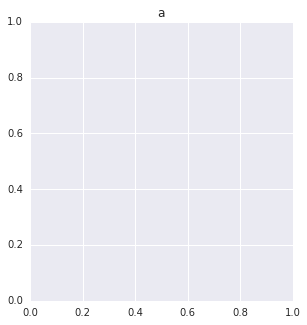

In [12]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
plt.figure(figsize=(16,6*len(indicators_flat)/3+1))
for i, indic in enumerate(indicators_flat):
    plt.subplot(len(indicators_flat)/3+1, 3, i+1)
    plt.title(indic[0])
    plt.hist(indic[1])
plt.show()

In [13]:
from datetime import datetime as dt
dt.fromtimestamp(1389024000).weekday()

0